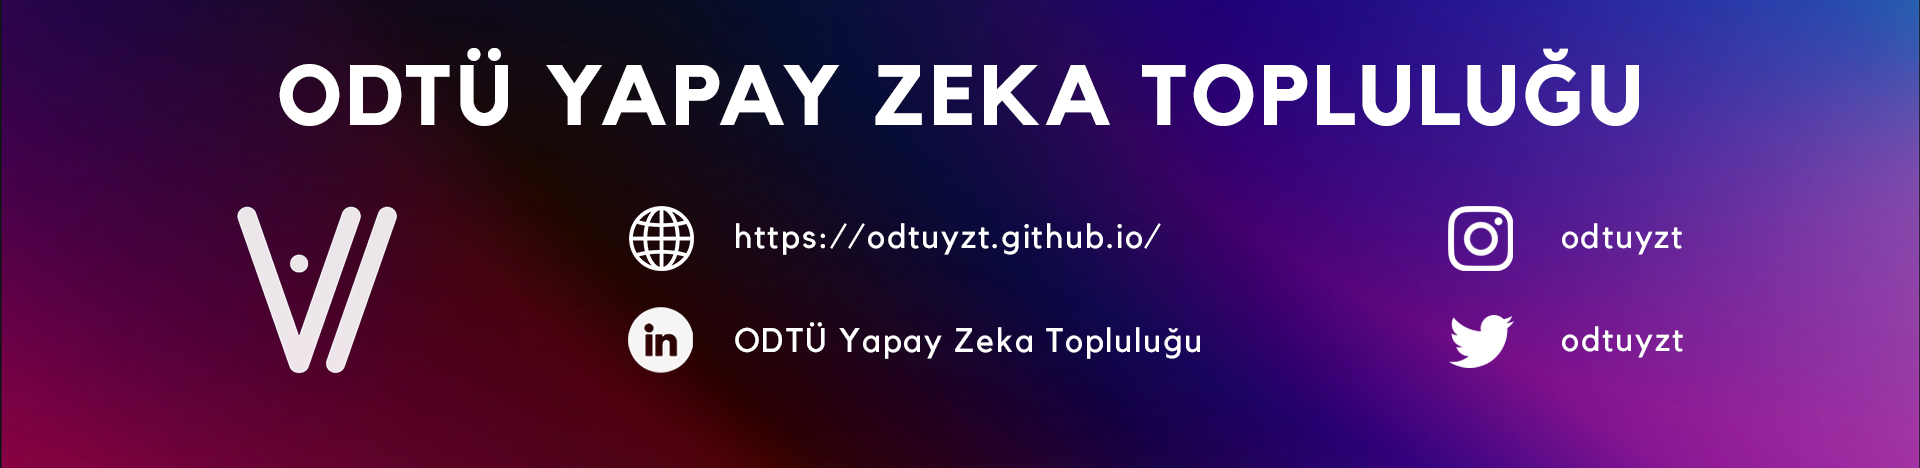

**Welcome to our RAG Workshop!** \\
In this interactive tutorial, we will dive into the intersection of natural language processing and information retrieval. Throughout this workshop, we'll explore how incorporating retrieval mechanisms can enhance the generation capabilities of language models. Whether you're a seasoned practitioner or just starting your journey in NLP, join us as we unlock the potential of retrieval-augmented generation together.

In [ ]:
!pip install -q langchain
!pip install -q torch
!pip install -q transformers
!pip install -q sentence-transformers
!pip install -q datasets
!pip install -q faiss-cpu
!pip install -q openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.1/289.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
from langchain.document_loaders import HuggingFaceDatasetLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AutoModelForCausalLM
from transformers import pipeline, BertTokenizer, BertModel
from langchain import HuggingFacePipeline
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
import torch

### Dataset

*  The dataset we are going to use is the famous Hugging Face dataset: __"databricks-dolly-15k"__ \
    which is an open source dataset of instruction-following records generated by Databricks; including brainstorming, classification, closed QA, generation, information extraction, open QA, and summarization.
<br></br>
<center><img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*1Ee2OQBslrw0ka7JFc2bJg.png" alt="ABCD" width="1000" height="400" style="display: block; margin: auto;" /></center>

In [ ]:
dataset_name = "databricks/databricks-dolly-15k"
page_content_column = "context"

# Create loader instance
loader = HuggingFaceDatasetLoader(dataset_name, page_content_column)

# load the data and display the first 15 entries
data = loader.load()
data[:2]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2516: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

[Document(page_content='"Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia\'s domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney."', metadata={'instruction': 'When did Virgin Australia start operating?', 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.', 'category': 'closed_qa'}),
 Document(page_content='""', metadata={'instruction': 'Which is a species of fish? Tope or Rope', 'response': 'Tope', 'category': 'classification'})]

Once we load the document, we can then transform it for our needs. \
What we will do here is basically _splitting the document into smaller chunks_ for the model, so that it can give more accurate results.




In [ ]:
# Create an instance of RecursiveCharacterTextSplitter class
# with specific parameters

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=150
)

docs = text_splitter.split_documents(data)

Now let's see the splitted document;

In [ ]:
docs[0]

Document(page_content='"Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia\'s domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney."', metadata={'instruction': 'When did Virgin Australia start operating?', 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.', 'category': 'closed_qa'})

### Embeddings

__Embeddings__ capture the semantic meaning of the text, which allows you to quickly and efficiently find other pieces of text which are similar.

<center><img src="https://miro.medium.com/v2/resize:fit:720/format:webp/0*kZaCc6_CFSd6K2tV.jpg" alt="embeddings" width="1000" height="400" style="display: block; margin: auto;" /></center>

The embedding model we are going to use will map sentences to **384 dimensional dense vectors** that can be clustered and later used for _semantic search_.

In [ ]:
model_path = "sentence-transformers/all-MiniLM-l6-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

embeddings = HuggingFaceEmbeddings(
    model_name = model_path,      # provide pretrained model path
    model_kwargs = model_kwargs,  # pass model config options
    encode_kwargs = encode_kwargs # pass encoding options
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Now let's test the embedding model;


In [ ]:
text = 'I love METU YZT!'
query_result = embeddings.embed_query(text)
print(query_result[:3])  # see the first three dimensions
print(len(query_result)) # see the vector size

[-0.07591929286718369, -0.04082451015710831, 0.011911625973880291]
384


##### __Your Turn!__
Let's implement our own embedding function and find similarities between sentences.

In [ ]:
def calculate_semantic_similarity(sentence1, sentence2):

    embeddings1 = embeddings.embed_query(sentence1)
    embeddings2 = embeddings.embed_query(sentence2)

    embeddings1 = torch.tensor(embeddings1)
    embeddings2 = torch.tensor(embeddings2)

    # TODO: Calculate cosine similarity between the embeddings, remember the formula
    dot_product = torch.dot(embeddings1, embeddings2)
    norm1 = torch.norm(embeddings1)
    norm2 = torch.norm(embeddings2)
    similarity = dot_product / (norm1 * norm2)
    ########

    similarity = torch.clamp(similarity, -1.0, 1.0) # for guaranteeing the interval, optional

    return similarity

### Click here to see the solution

In [ ]:
def calculate_semantic_similarity_answer(sentence1, sentence2):

    embeddings1 = embeddings.embed_query(sentence1)
    embeddings2 = embeddings.embed_query(sentence2)

    embeddings1 = torch.tensor(embeddings1)
    embeddings2 = torch.tensor(embeddings2)

    # TODO: Calculate cosine similarity between the embeddings, remember the formula
    dot_product = torch.dot(embeddings1, embeddings2)
    norm1 = torch.norm(embeddings1)
    norm2 = torch.norm(embeddings2)
    similarity = dot_product / (norm1 * norm2)
    ########

    similarity = torch.clamp(similarity, -1.0, 1.0) # for guaranteeing the interval, optional

    return similarity

### Now let's test our function;

In [ ]:
sentence1 = "I love METU YZT!"
sentence2 = "METU YZT is my favorite!"

sentence3 = "I don't like orange."
sentence4 = "I don't like orange."

semantic_similarity1 = calculate_semantic_similarity(sentence1, sentence2)
print(f"Semantic Similarity: {semantic_similarity1}")

semantic_similarity2 = calculate_semantic_similarity(sentence3, sentence4)
print(f"Semantic Similarity: {semantic_similarity2}")

Semantic Similarity: 0.8198714852333069
Semantic Similarity: 1.0


### Vector Stores

* Now that we have the embedding model, we need a __virtual space to store the vectors__ to function as a database. \
We will retrieve vectors from those vector stores based on their similarity score.

* We will use __FAISS__, a vector space developed by META, and it uses _Euclidean Distance_ as its similarity parameter by default.
<br></br>
<center><img src="https://miro.medium.com/v2/resize:fit:720/format:webp/0*N3Cgfs4Fj5nHxdd-.png" alt="faiss" width="1000" height="400" style="display: block; margin: auto;" /></center>

In [ ]:
docs = docs[:10000]
vectorDB = FAISS.from_documents(docs, embeddings)

# this part may take some time, be patient :)

Now that we have the vector store set up, let's try a question;


In [ ]:
question = "When was lamborghini sold to the Volkswagen Group?"
searchDocs = vectorDB.similarity_search(question)
print(searchDocs[0])

page_content="Leimer and retired in 1974. The company went bankrupt in 1978, and was placed in the receivership of brothers Jean-Claude and Patrick Mimran in 1980. The Mimrans purchased the company out of receivership by 1984 and invested heavily in its expansion. Under the Mimrans' management, Lamborghini's model line was expanded from the Countach to include the Jalpa sports car and the LM002 high-performance off-road vehicle.\\n\\nThe Mimrans sold Lamborghini to the Chrysler Corporation in 1987. After replacing the Countach with the Diablo and discontinuing the Jalpa and the LM002, Chrysler sold Lamborghini to Malaysian investment group Mycom Setdco and Indonesian group V'Power Corporation in 1994. In 1998, Mycom Setdco and V'Power sold Lamborghini to the Volkswagen Group where it was placed under the control of the group's Audi division. New products and model lines were introduced to the brand's portfolio and brought to the market and saw an increased productivity for the brand La

Now, we are almost ready for the whole RAG pipeline.\
We now need to utilize a LLM to actually _"generate"_ new answers __based on the context retrieved by the vector store__.
<br></br>
<center><img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*tdPlvSI-dctBCbbRdG26jA.png" alt="fullp" width="1000" height="400" style="display: block; margin: auto;" /></center>

In [ ]:
model_name = "Intel/dynamic_tinybert"

tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          padding = True,
                                          truncation = True,
                                          max_length = 512)

question_answerer = pipeline(
    "question-answering",
    model=model_name,
    tokenizer=tokenizer,
    return_tensors='pt'
)

tokenizer_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Now let's test the question answering pipeline;

In [ ]:
question_answerer(question = "What is the best society in METU?",
                  context = "There are more than 50 societies in our university, but YZT is by far the best.")

{'score': 0.9934405088424683, 'start': 56, 'end': 59, 'answer': 'YZT'}

### Retrievers

Once the data is in database, the LLM model is prepared, and the pipeline is created, we need to _retrieve the data_.
* A __retriever__ is an interface that returns documents from the query.
<br></br>
<center><img src="https://miro.medium.com/v2/resize:fit:720/format:webp/0*iCyJRTkc8oI93Bsh.png" alt="retriever" width="1000" height="400" style="display: block; margin: auto;" /></center>

In [ ]:
retriever = vectorDB.as_retriever()

docs = retriever.get_relevant_documents("When was Lamborghini sold to the Volkswagen Group?")
print(docs[0])

page_content="Leimer and retired in 1974. The company went bankrupt in 1978, and was placed in the receivership of brothers Jean-Claude and Patrick Mimran in 1980. The Mimrans purchased the company out of receivership by 1984 and invested heavily in its expansion. Under the Mimrans' management, Lamborghini's model line was expanded from the Countach to include the Jalpa sports car and the LM002 high-performance off-road vehicle.\\n\\nThe Mimrans sold Lamborghini to the Chrysler Corporation in 1987. After replacing the Countach with the Diablo and discontinuing the Jalpa and the LM002, Chrysler sold Lamborghini to Malaysian investment group Mycom Setdco and Indonesian group V'Power Corporation in 1994. In 1998, Mycom Setdco and V'Power sold Lamborghini to the Volkswagen Group where it was placed under the control of the group's Audi division. New products and model lines were introduced to the brand's portfolio and brought to the market and saw an increased productivity for the brand La

### Retrieval QA Chain:
Now, we're going to use a __RetrievalQA Chain__ to find the answer to a question.
<br></br>
<center><img src="https://miro.medium.com/v2/resize:fit:720/format:webp/0*BnhkosPmaEq0xe6E.jpeg" alt="retrQAchain" width="1000" height="400" style="display: block; margin: auto;" /></center>
<br></br>

The RetrievalQA chain combines question-answering with a retrieval step.

To create it, we use a language model and a vector database as a retriever.
* By default, we put all the data together in a single batch, where the chain type is "stuff" when asking the language model.
* But if we have a lot of information and it doesn't all fit at once, we can use methods like __MapReduce__, __Refine__, and __MapRerank__.

Now, we will use the famous __GPT-3.5__ as our generative model;

In [ ]:
retriever = vectorDB.as_retriever(search_kwagrs={"k":4})

# completion llm
llm = ChatOpenAI(
    openai_api_key=...,
    model_name='gpt-3.5-turbo',
    temperature=0.1 # allow the model to be more generative
)

qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


Finally, call the QA chain with the question we want to ask;

In [ ]:
question = "Who is Thomas Jefferson?"
result = qa.run(question)
print(result)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Thomas Jefferson was an American statesman, diplomat, lawyer, architect, philosopher, and Founding Father who served as the third president of the United States from 1801 to 1809. He was the primary author of the Declaration of Independence and played significant roles in the early history of the United States.


To see if GPT-3.5 actually used the retrieved document and not its pre-trained knowledge, let's check the retrieved document;

In [ ]:
docs = retriever.get_relevant_documents(question)
print(docs[0])

page_content='"Thomas Jefferson (April 13, 1743 \\u2013 July 4, 1826) was an American statesman, diplomat, lawyer, architect, philosopher, and Founding Father who served as the third president of the United States from 1801 to 1809. Among the Committee of Five charged by the Second Continental Congress with authoring the Declaration of Independence, Jefferson was the Declaration\'s primary author. Following the American Revolutionary War and prior to becoming the nation\'s third president in 1801, Jefferson was the first United States secretary of state under George Washington and then the nation\'s second vice president under John Adams."' metadata={'instruction': 'Who is Thomas Jefferson?', 'response': "Thomas Jefferson (April 13, 1743 – July 4, 1826) was an American statesman, diplomat, lawyer, architect, philosopher, and Founding Father who served as the third president of the United States from 1801 to 1809. Among the Committee of Five charged by the Second Continental Congress wi

As we can see, there is almost one-to-one correspondance with the retrieved document and the answer generated by our RAG pipeline.

That's pretty much it! From now on, you can implement the same pipeline on your own dataset (lecture notes, mails, articles...) and perform question-answering on your specific data.


**THANK YOU SO MUCH FOR BEING A PART OF THIS WORKSHOP, HOPE YOU ENJOYED IT 😺**